In [1]:
import os
import numpy as np
import requests
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras import preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=200000)

17464789/17464789 [==============================] - 2s 0us/step


In [5]:
glove_path = '/content/drive/MyDrive/'                                            
glove_file = '/content/drive/MyDrive/glove.6B.100d.txt'
 
embedding_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_index[word] = coefs

print("Number of word vectors:", len(embedding_index))

Number of word vectors: 400000


In [6]:
word_index = imdb.get_word_index()
embedding_dim = 100
match = 0
misses = 0

embedding_matrix = np.zeros((200000, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        match += 1
    else:
        misses += 1
        
print(embedding_matrix.shape)
print("Number of matches:", match)
print("Number of misses:", misses)

1641221/1641221 [==============================] - 0s 0us/step
(200000, 100)
Number of matches: 60150
Number of misses: 28434


In [7]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen=128)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,maxlen=128)

In [8]:
inputShape = tf.keras.layers.Input(shape=(128))

embedding_layer = tf.keras.layers.Embedding(
    200000,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

embeddings = embedding_layer(inputShape)
x = tf.keras.layers.Flatten()(embeddings)
x = tf.keras.layers.Dense(128,activation='sigmoid')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model1 = tf.keras.Model(inputs = inputShape, outputs = x)

model1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 100)          20000000  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 128)               1638528   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,638,657
Trainable params: 1,638,657
Non-trai

In [ ]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/imdb-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-3)


model1.compile(
    loss = 'binary_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history1 = model1.fit(
    x_train,y_train,
    epochs = 10,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=my_callbacks)

Epoch 1/10
196/196 [==============================] - 15s 72ms/step - loss: 0.7439 - accuracy: 0.5084 - val_loss: 0.6925 - val_accuracy: 0.5146 - lr: 0.0010
Epoch 2/10
196/196 [==============================] - 12s 62ms/step - loss: 0.6921 - accuracy: 0.5461 - val_loss: 0.6863 - val_accuracy: 0.5515 - lr: 0.0010
Epoch 3/10
196/196 [==============================] - 11s 58ms/step - loss: 0.6491 - accuracy: 0.6257 - val_loss: 0.6832 - val_accuracy: 0.5665 - lr: 0.0010
Epoch 4/10
196/196 [==============================] - 16s 83ms/step - loss: 0.6038 - accuracy: 0.6806 - val_loss: 0.6826 - val_accuracy: 0.5786 - lr: 0.0010
Epoch 5/10
196/196 [==============================] - 12s 62ms/step - loss: 0.5603 - accuracy: 0.7172 - val_loss: 0.7018 - val_accuracy: 0.5815 - lr: 0.0010
Epoch 6/10
196/196 [==============================] - 1s 6ms/step - loss: 0.5029 - accuracy: 0.7624 - val_loss: 0.7455 - val_accuracy: 0.5793 - lr: 0.0010
Epoch 7/10
196/196 [==============================] - 1s 5ms

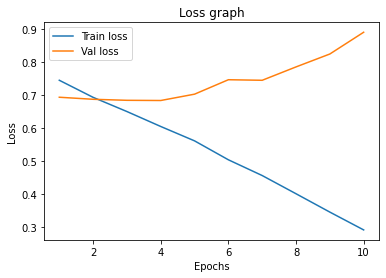

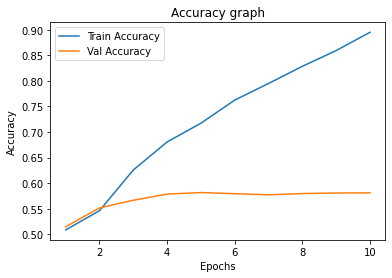

In [ ]:
# Plot training process
dict1 = history1.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()

#print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [9]:
inputShape = tf.keras.layers.Input(shape=(128))

embedding_layer = tf.keras.layers.Embedding(
    200000,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

embeddings = embedding_layer(inputShape)
x = tf.keras.layers.LSTM(64,dropout=0.5)(embeddings)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs = inputShape, outputs = x)

model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 100)          20000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65  

In [11]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/imdb-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-3)


model2.compile(
    loss = 'binary_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history2 = model2.fit(
    x_train,y_train,
    epochs = 20,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=my_callbacks)

Epoch 1/20
196/196 [==============================] - 14s 63ms/step - loss: 0.6788 - accuracy: 0.5703 - val_loss: 0.6598 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 2/20
196/196 [==============================] - 3s 15ms/step - loss: 0.6620 - accuracy: 0.6015 - val_loss: 0.6964 - val_accuracy: 0.5690 - lr: 0.0010
Epoch 3/20
196/196 [==============================] - 12s 59ms/step - loss: 0.6477 - accuracy: 0.6238 - val_loss: 0.6387 - val_accuracy: 0.6367 - lr: 0.0010
Epoch 4/20
196/196 [==============================] - 3s 14ms/step - loss: 0.6316 - accuracy: 0.6377 - val_loss: 0.6493 - val_accuracy: 0.6146 - lr: 0.0010
Epoch 5/20
196/196 [==============================] - 11s 57ms/step - loss: 0.6160 - accuracy: 0.6566 - val_loss: 0.6265 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 6/20
196/196 [==============================] - 11s 58ms/step - loss: 0.6008 - accuracy: 0.6706 - val_loss: 0.5641 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 7/20
196/196 [==============================] - 3s 14m

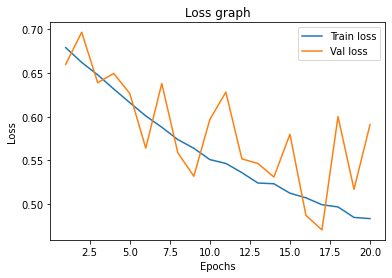

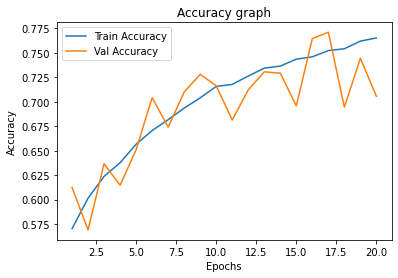

In [12]:
# Plot training process
dict1 = history2.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()

#print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [ ]:
inputShape = tf.keras.layers.Input(shape=(128))

embedding_layer = tf.keras.layers.Embedding(
    200000,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

embeddings = embedding_layer(inputShape)
x = tf.keras.layers.Flatten()(embeddings)
x = tf.keras.layers.Dense(128,activation='sigmoid')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model3 = tf.keras.Model(inputs = inputShape, outputs = x)
model3.get_layer(name='embedding_5').trainable = False
model3.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 128, 100)          20000000  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               1638528   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 21,638,657
Trainable params: 1,638,657
Non-tr

In [ ]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/imdb-loss1_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-3)


model2.compile(
    loss = 'binary_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history2 = model2.fit(
    x_train,y_train,
    epochs = 10,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=my_callbacks)

Epoch 1/10
196/196 [==============================] - 12s 59ms/step - loss: 0.2801 - accuracy: 0.8660 - val_loss: 1.1454 - val_accuracy: 0.5739 - lr: 0.0010
Epoch 2/10
196/196 [==============================] - 10s 53ms/step - loss: 0.2404 - accuracy: 0.8800 - val_loss: 1.2254 - val_accuracy: 0.5747 - lr: 0.0010
Epoch 3/10
196/196 [==============================] - 1s 7ms/step - loss: 0.2244 - accuracy: 0.8875 - val_loss: 1.1456 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 4/10
196/196 [==============================] - 1s 7ms/step - loss: 0.2053 - accuracy: 0.8961 - val_loss: 1.3545 - val_accuracy: 0.5738 - lr: 0.0010
Epoch 5/10
196/196 [==============================] - 1s 5ms/step - loss: 0.1956 - accuracy: 0.8988 - val_loss: 1.2326 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 6/10
196/196 [==============================] - 1s 7ms/step - loss: 0.1913 - accuracy: 0.9018 - val_loss: 1.4663 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 7/10
196/196 [==============================] - 1s 5ms/step 

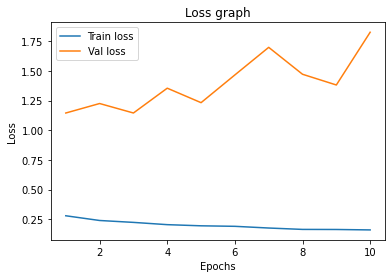

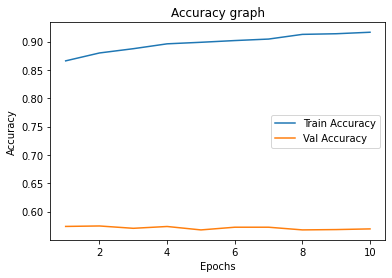

In [ ]:
# Plot training process
dict1 = history2.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()

#print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [ ]:
test_out = model1.predict(x_test)
predictions = np.round(test_out)
test_diff = predictions.T-y_test
test_errors = np.count_nonzero(test_diff)
test_acc = (1-test_errors/len(predictions))*100
print("Test accuracy =", np.round(test_acc, 1), "%")
print()

782/782 [==============================] - 1s 2ms/step
Test accuracy = 58.1 %

